<a href="https://colab.research.google.com/github/richayanamandra/GenAI-Experiments/blob/main/genAI_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
dataset_choice='mnist'
epochs=50
batch_size=64
noise_dim=100
learning_rate=0.0002
save_interval=5


In [ ]:
if dataset_choice == 'mnist':
    (x_train, _), (_, _) = mnist.load_data()
else:
    from tensorflow.keras.datasets import fashion_mnist
    (x_train, _), (_, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)

print("Dataset shape:", x_train.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset shape: (60000, 28, 28, 1)


In [ ]:
def build_generator(noise_dim):
    model = Sequential()

    model.add(layers.Dense(256, input_dim=noise_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(28 * 28 * 1, activation='sigmoid'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

generator = build_generator(noise_dim)
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def build_discriminator():
    model=Sequential()

    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator=build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate, 0.5),
    metrics=['accuracy']
)

discriminator.trainable = False

gan = Sequential([
    generator,
    discriminator
])

gan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate, 0.5)
)


In [ ]:
def save_generated_images(epoch, generator, noise_dim):
    os.makedirs("generated_samples", exist_ok=True)
    noise = np.random.normal(0, 1, (25, noise_dim))
    gen_images = generator.predict(noise, verbose=0)

    fig, axs = plt.subplots(5, 5, figsize=(5, 5))
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.savefig(f"generated_samples/epoch_{epoch:02d}.png")
    plt.close()


def train_gan(generator, discriminator, gan, x_train, epochs, batch_size):

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(1, epochs + 1):


        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)




        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, real)


        print(
            f"Epoch {epoch}/{epochs} | "
            f"D_loss: {d_loss[0]:.2f} | "
            f"D_acc: {d_loss[1]*100:.2f}% | "
            f"G_loss: {g_loss:.2f}"
        )

        if epoch % save_interval == 0:
            save_generated_images(epoch, generator, noise_dim)


In [ ]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    gan=gan,
    x_train=x_train,
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/50 | D_loss: 0.19 | D_acc: 96.97% | G_loss: 2.94
Epoch 2/50 | D_loss: 0.19 | D_acc: 97.01% | G_loss: 2.96
Epoch 3/50 | D_loss: 0.19 | D_acc: 97.07% | G_loss: 2.99
Epoch 4/50 | D_loss: 0.19 | D_acc: 97.03% | G_loss: 3.00
Epoch 5/50 | D_loss: 0.19 | D_acc: 96.56% | G_loss: 3.03
Epoch 6/50 | D_loss: 0.20 | D_acc: 95.95% | G_loss: 3.05
Epoch 7/50 | D_loss: 0.20 | D_acc: 95.91% | G_loss: 3.06
Epoch 8/50 | D_loss: 0.20 | D_acc: 95.96% | G_loss: 3.07
Epoch 9/50 | D_loss: 0.20 | D_acc: 96.00% | G_loss: 3.08
Epoch 10/50 | D_loss: 0.20 | D_acc: 96.01% | G_loss: 3.09
Epoch 11/50 | D_loss: 0.20 | D_acc: 96.05% | G_loss: 3.11
Epoch 12/50 | D_loss: 0.20 | D_acc: 96.03% | G_loss: 3.13
Epoch 13/50 | D_loss: 0.21 | D_acc: 95.99% | G_loss: 3.14
Epoch 14/50 | D_loss: 0.21 | D_acc: 96.00% | G_loss: 3.16
Epoch 15/50 | D_loss: 0.21 | D_acc: 95.97% | G_loss: 3.18
Epoch 16/50 | D_loss: 0.21 | D_acc: 95.97% | G_loss: 3.19
Epoch 17/50 | D_loss: 0.21 | D_acc: 96.01% | G_loss: 3.22
Epoch 18/50 | D_loss: 0

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("generated_samples", exist_ok=True)
epochs_to_save = list(range(save_interval, epochs + 1, save_interval))

for epoch in epochs_to_save:
    noise = np.random.normal(0, 1, (25, noise_dim))
    gen_images = generator.predict(noise, verbose=0)

    fig, axs = plt.subplots(5, 5, figsize=(5, 5))
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.savefig(f"generated_samples/epoch_{epoch:02d}.png")
    plt.close()

print("generated_samples folder created with correct epoch-wise files!")


generated_samples folder created with correct epoch-wise files!


In [ ]:

import os

files = os.listdir("final_generated_images")
print("Total images generated:", len(files))
print("Sample files:", files[:10])


Total images generated: 100
Sample files: ['img_33.png', 'img_17.png', 'img_7.png', 'img_69.png', 'img_13.png', 'img_83.png', 'img_92.png', 'img_51.png', 'img_60.png', 'img_79.png']


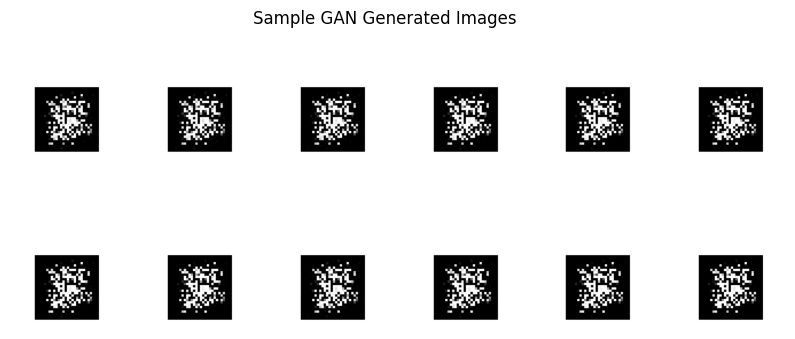

In [ ]:
# ================================
# PROOF CELL B: Display generated images
# ================================

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 6, figsize=(10, 4))
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"final_generated_images/img_{i+1}.png")
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle("Sample GAN Generated Images")
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model_path = "mnist_classifier.h5"

if not os.path.exists(model_path):
    print("Training classifier once (pre-trained model)...")

    (x_train_c, y_train_c), (x_test_c, y_test_c) = mnist.load_data()
    x_train_c = x_train_c / 255.0
    x_test_c = x_test_c / 255.0
    x_train_c = np.expand_dims(x_train_c, -1)
    x_test_c = np.expand_dims(x_test_c, -1)

    classifier = Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    classifier.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    classifier.fit(x_train_c, y_train_c, epochs=3, batch_size=128, verbose=1)
    classifier.save(model_path)

else:
    classifier = load_model(model_path)

print("Pre-trained classifier ready!")


Training classifier once (pre-trained model)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8543 - loss: 0.4878
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9819 - loss: 0.0617
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9867 - loss: 0.0419


Pre-trained classifier ready!


In [ ]:

from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

predicted_labels = []

for i in range(1, 101):
    img_path = f"final_generated_images/img_{i}.png"

    img = plt.imread(img_path)
    if img.ndim == 3:
        img = img[:, :, 0]

    img = tf.image.resize(img[..., np.newaxis], (28, 28)).numpy()
    img = img / 255.0

    img = np.expand_dims(img, axis=0)

    pred = classifier.predict(img, verbose=0)
    label = np.argmax(pred)
    predicted_labels.append(label)

distribution = Counter(predicted_labels)

print("Predicted Label Distribution:")
for label, count in sorted(distribution.items()):
    print(f"Digit {label}: {count} images")


Predicted Label Distribution:
Digit 5: 100 images


Predicted label: 5


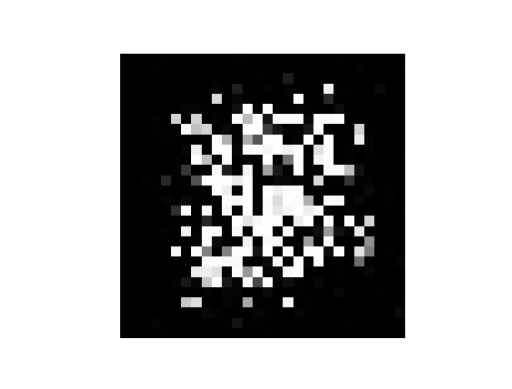

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread("final_generated_images/img_1.png")

plt.imshow(img, cmap='gray')
plt.axis('off')

if img.ndim == 3:
    img = img[:, :, 0]

img = tf.image.resize(img[..., np.newaxis], (28, 28))

img = img / 255.0

img = np.expand_dims(img, axis=0)

pred = classifier.predict(img, verbose=0)

print("Predicted label:", np.argmax(pred))
